Implementation of Inception Module with dimension reductio


c_in: input feature map's channel size <br>
c_red[3x3]: output feature map's channel size for 1x1 dimension reduction convolutions in 3x3 convolution block <br> 
c_red[5x5]: output feature map's channel size for 1x1 dimension reduction convolutions in 5x5 convolution block <br> 
c_out[1x1]: output feature map's channel size for 1x1 convolution <br>
c_out[3x3]: output feature map's channel size for 3x3 convolution <br>
c_out[5x5]: output feature map's channel size for 5x5 convolution <br>
c_out["max"]: output feature map's channel size for max pooling <br>


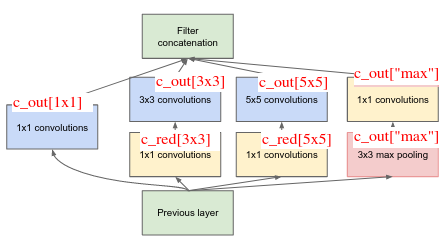

In [1]:
from torch import nn
from torchsummary import summary
import cv2
import torchvision.transforms as transforms
import torch

class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red : dict, c_out : dict):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
        """
        super().__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            nn.ReLU(),
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            nn.ReLU(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            nn.ReLU()
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            nn.ReLU(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            nn.ReLU()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            nn.ReLU()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out


Let's create an InceptionBlock object and pass one image trough.
We have a 3x224x224 image so InceptionBlock, we want that 3x3 convs gives 32, 5x5 convs and pooling layer gives 8 and  1x1 conv gives 16 feature maps. So as output we will obtain 32+8+8+16 = 64 feature maps from one inception module.

In [2]:
block = InceptionBlock(3, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8})

summary(block, input_size = (3, 224, 224), batch_size = 1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 16, 224, 224]              64
       BatchNorm2d-2          [1, 16, 224, 224]              32
              ReLU-3          [1, 16, 224, 224]               0
            Conv2d-4          [1, 32, 224, 224]             128
       BatchNorm2d-5          [1, 32, 224, 224]              64
              ReLU-6          [1, 32, 224, 224]               0
            Conv2d-7          [1, 32, 224, 224]           9,248
       BatchNorm2d-8          [1, 32, 224, 224]              64
              ReLU-9          [1, 32, 224, 224]               0
           Conv2d-10          [1, 16, 224, 224]              64
      BatchNorm2d-11          [1, 16, 224, 224]              32
             ReLU-12          [1, 16, 224, 224]               0
           Conv2d-13           [1, 8, 224, 224]           3,208
      BatchNorm2d-14           [1, 8, 2

In [3]:
img = cv2.imread("data_flowers/daisy/100080576_f52e8ee070_n.jpg") 

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])  

img = transform(img)
img = img.unsqueeze(0)

output = block(img)

print(output.shape)



torch.Size([1, 64, 224, 224])


After implementing an Inception Module, creating original InceptionV1 architecture according to the paper's explanation is the easy part!

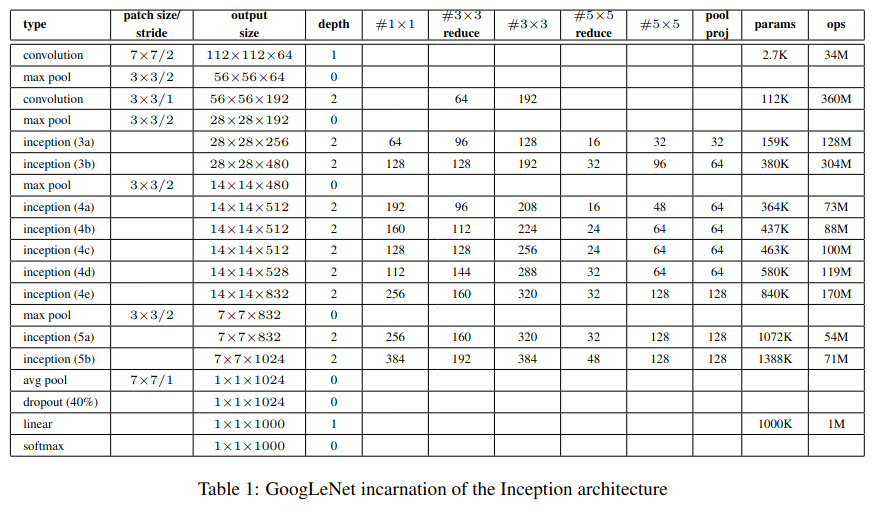

In [4]:
class InceptionV1(nn.Module):

    def __init__(self, num_classes=3):
        super().__init__()
       
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
        )
        
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(192, c_red={"3x3": 96, "5x5": 16}, c_out={"1x1": 64, "3x3": 128, "5x5": 32, "max": 32}), #gives 256 output feature maps after concat
            InceptionBlock(256, c_red={"3x3": 128, "5x5": 32}, c_out={"1x1": 128, "3x3": 192, "5x5": 96, "max": 64}), # gives 480 output feature maps after concat
            nn.MaxPool2d(3, stride=2, padding=1),  # 28x28 => 14x14
            InceptionBlock(480, c_red={"3x3": 96, "5x5": 16}, c_out={"1x1": 192, "3x3": 208, "5x5": 48, "max": 64}), # gives 512 output feature maps after concat
            InceptionBlock(512, c_red={"3x3": 112, "5x5": 24}, c_out={"1x1": 160, "3x3": 224, "5x5": 64, "max": 64}), # gives 512 output feature maps after concat
            InceptionBlock(512, c_red={"3x3": 128, "5x5": 24}, c_out={"1x1": 128, "3x3": 256, "5x5": 64, "max": 64}), # gives 512 output feature maps after concat
            InceptionBlock(512, c_red={"3x3": 144, "5x5": 32}, c_out={"1x1": 112, "3x3": 288, "5x5": 64, "max": 64}), # gives 528 output feature maps after concat
            InceptionBlock(528, c_red={"3x3": 160, "5x5": 32}, c_out={"1x1": 256, "3x3": 320, "5x5": 128, "max": 128}), # gives 832 output feature maps after concat
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8 
            InceptionBlock(832, c_red={"3x3": 160, "5x5": 32}, c_out={"1x1": 256, "3x3": 320, "5x5": 128, "max": 128}), # gives 832 output feature maps after concat
            InceptionBlock(832, c_red={"3x3": 192, "5x5": 48}, c_out={"1x1": 384, "3x3": 384, "5x5": 128, "max": 128}), # gives 1024 output feature maps after concat
            nn.AvgPool2d((7,7), stride=1) # from 1024x7x7 to 1024x1x1
        )
        
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.Flatten(), # 
            nn.Linear(1024*1*1, num_classes)
        )
        
        
    def forward(self, x):
        print("Input shape", x.shape)
        x = self.input_net(x)
        print("Feature maps shape after input convoutions")
        print(x.shape)
        x = self.inception_blocks(x)
        print("Feature maps after inception block")
        print(x.shape)
        x = self.output_net(x)
        print("Final output shape")
        print(x.shape)
        return x     

In [5]:
model = InceptionV1()
summary(model, input_size = (3, 224, 224), batch_size = 1)


Input shape torch.Size([2, 3, 224, 224])
Feature maps shape after input convoutions
torch.Size([2, 192, 28, 28])
Feature maps after inception block
torch.Size([2, 1024, 1, 1])
Final output shape
torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 110, 110]           9,472
       BatchNorm2d-2          [1, 64, 110, 110]             128
              ReLU-3          [1, 64, 110, 110]               0
         MaxPool2d-4            [1, 64, 55, 55]               0
            Conv2d-5           [1, 192, 55, 55]         110,784
       BatchNorm2d-6           [1, 192, 55, 55]             384
              ReLU-7           [1, 192, 55, 55]               0
         MaxPool2d-8           [1, 192, 28, 28]               0
            Conv2d-9            [1, 64, 28, 28]          12,352
      BatchNorm2d-10            [1, 64, 28, 28]             128
             ReLU

Finally, we are able to see with our own eyes that InceptionV1 has ~28 times less parameters an the total model size is 7x smaller than VGG16 ;)